# Forecasting - Exercise

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Dataset: Alcohol sales

https://fred.stlouisfed.org/series/S4248SM144NCEN
Merchant Wholesalers, Except Manufacturers' Sales Branches and Offices: Nondurable Goods: Beer, Wine, and Distilled Alcoholic Beverages Sales

## Load data

In [2]:
Y = pd.read_csv("./data/Alcohol_Sales2024.csv")
Y.head()

,DATE,S4248SM144NCEN
0,1992-01-01,3459.0
1,1992-02-01,3458.0
2,1992-03-01,4002.0
3,1992-04-01,4564.0
4,1992-05-01,4221.0


In [3]:
Y.set_index('DATE', inplace=True)
Y.index = pd.PeriodIndex(Y.index, freq='M')
y = Y['S4248SM144NCEN']
y.head()

DATE
1992-01    3459.0
1992-02    3458.0
1992-03    4002.0
1992-04    4564.0
1992-05    4221.0
Freq: M, Name: S4248SM144NCEN, dtype: float64

<Axes: xlabel='DATE'>

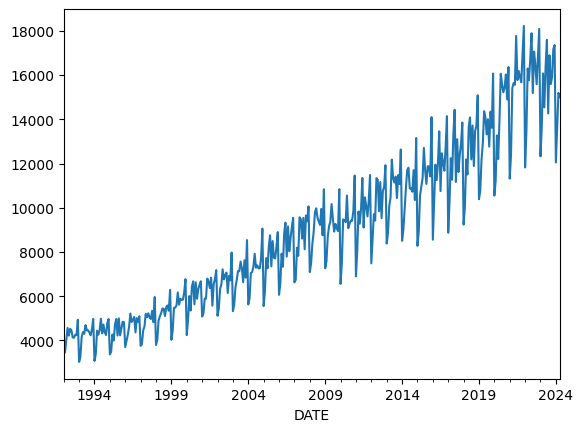

In [4]:
y.plot()

## Split data

In [5]:
from sktime.split import temporal_train_test_split

In [6]:
y_train, y_test = temporal_train_test_split(y)
y_train.shape, y_test.shape

((291,), (97,))

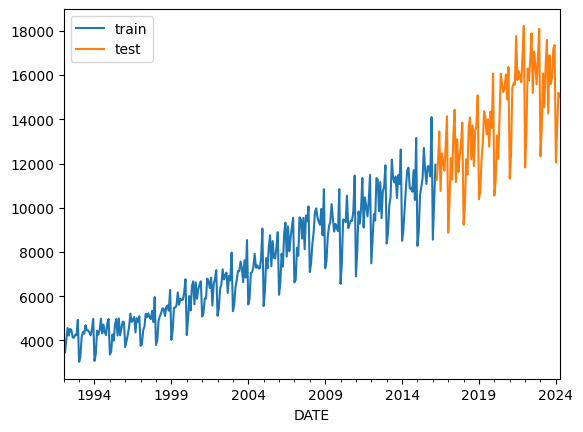

In [7]:
y_train.plot(label='train')
y_test.plot(label='test')
plt.legend()
plt.show()

---

## Exercise
Find the best possible forecasting model for the alcohol sales dataset in terms of MAE (mean absolute error).
Remember not to use the test set for model selection.

---

In [8]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.forecasting.model_evaluation import evaluate
from sktime.split import ExpandingWindowSplitter
from sktime.forecasting.model_selection import ForecastingGridSearchCV

In [9]:
mae = MeanAbsoluteError()
fh = np.arange(1, len(y_test) + 1)
cv = ExpandingWindowSplitter(fh, initial_window=96, step_length=12)

In [10]:
# how many splits?
splitted = list(cv.split(y_train))
len(splitted)

9

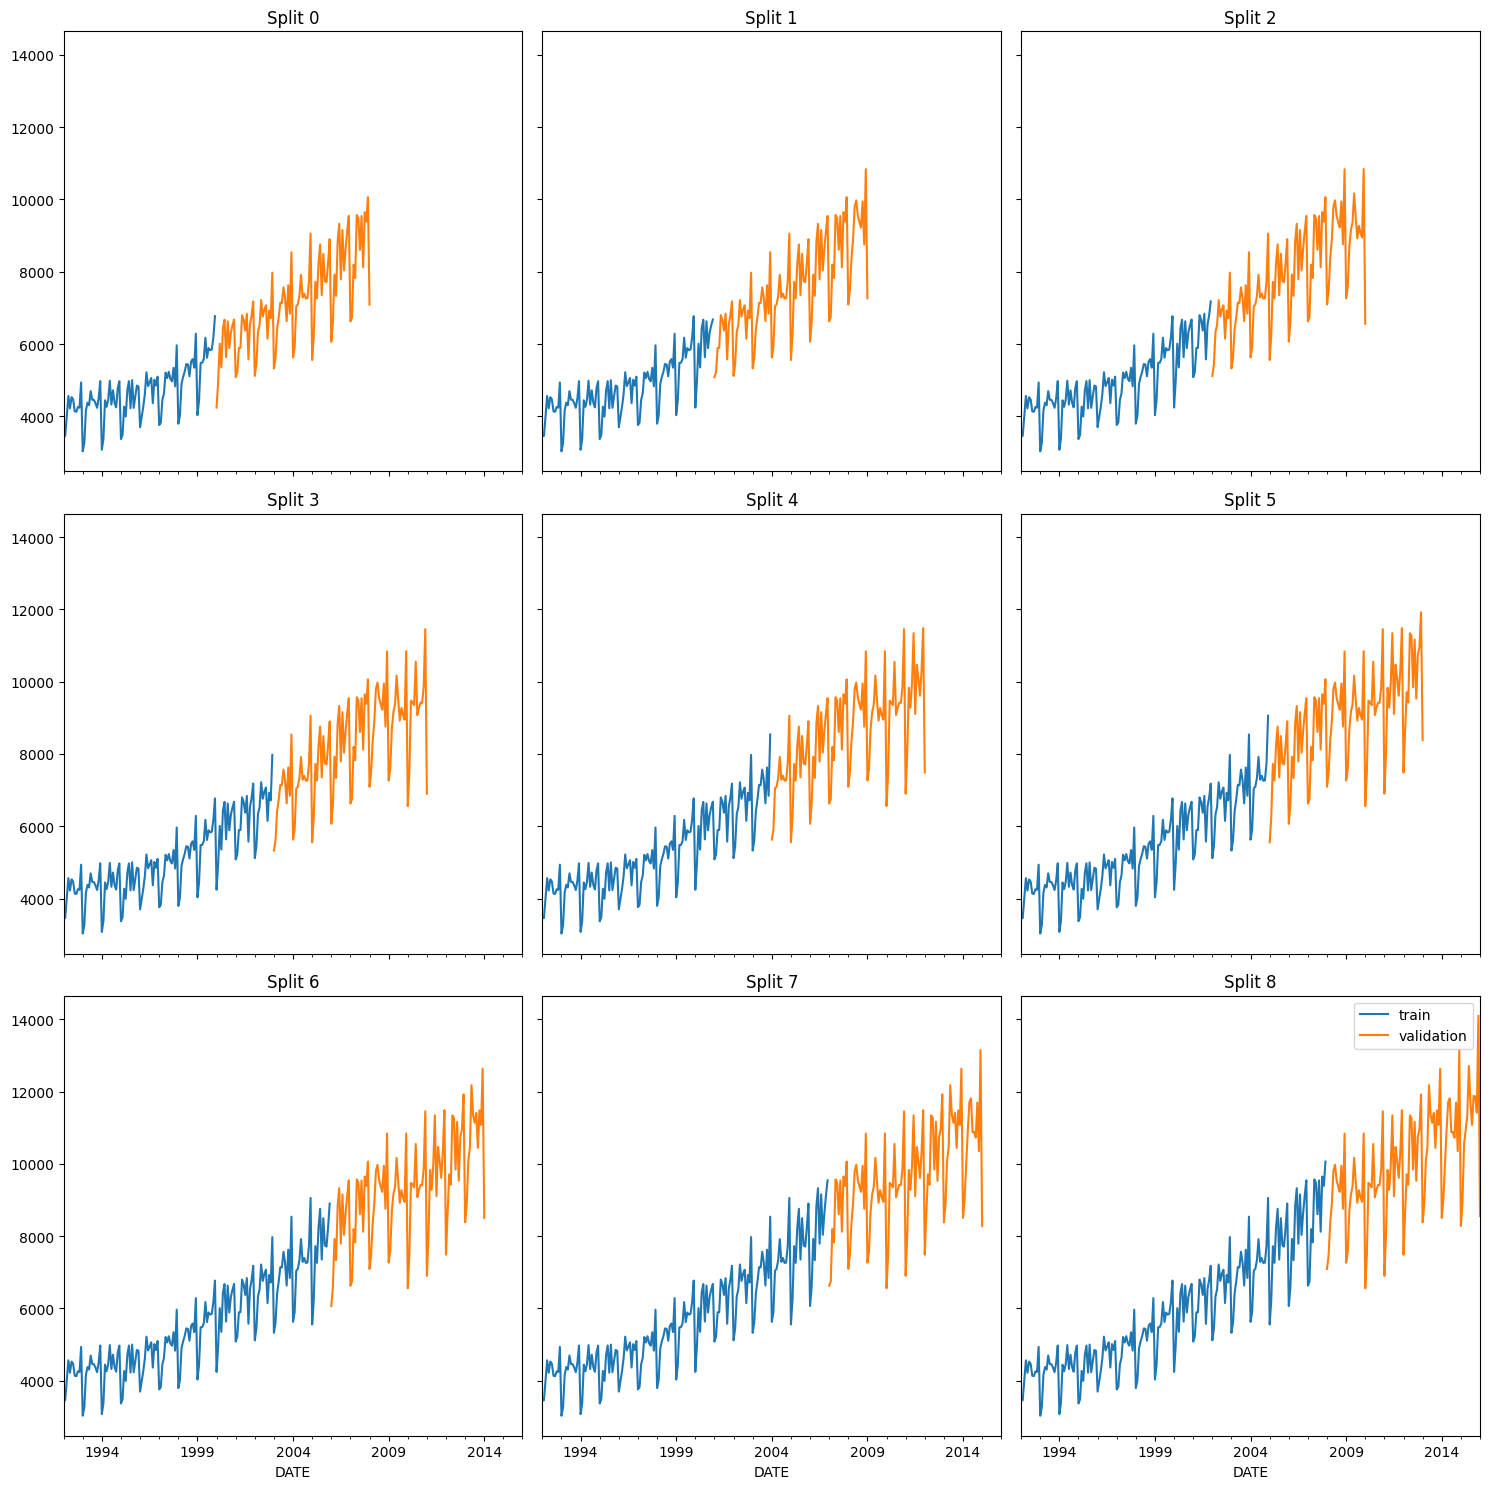

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
for i, (train, test) in enumerate(splitted):
    axs[i // 3, i % 3].set_title(f"Split {i}")
    y.iloc[train].plot(ax=axs[i // 3, i % 3], label='train')
    y.iloc[test].plot(ax=axs[i // 3, i % 3], label='validation')
plt.tight_layout()
plt.legend()
plt.show()

## Naive forecasting

In [12]:
from sktime.forecasting.naive import NaiveForecaster

### Mean

#### Cross-validation

In [13]:
scores_df = evaluate(NaiveForecaster(strategy="mean"), cv=cv, y=y_train, scoring=MeanAbsoluteError())
scores_df["test_MeanAbsoluteError"].mean()

/Users/francesco/miniforge3/envs/2024_generali_ts_course_native/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:400: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/Users/francesco/miniforge3/envs/2024_generali_ts_course_native/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/Users/francesco/miniforge3/envs/2024_generali_ts_course_native/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:400: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/Users/francesco/miniforge3/envs/2024_generali_ts_course_native/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'M

3341.7683294975463

#### Performance on the test set

In [14]:
forecaster = NaiveForecaster(strategy="mean")

In [15]:
forecaster.fit(y_train)

NaiveForecaster(strategy='mean')

In [16]:
y_pred = forecaster.predict(fh)

/Users/francesco/miniforge3/envs/2024_generali_ts_course_native/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:400: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/Users/francesco/miniforge3/envs/2024_generali_ts_course_native/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/Users/francesco/miniforge3/envs/2024_generali_ts_course_native/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:400: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/Users/francesco/miniforge3/envs/2024_generali_ts_course_native/lib/python3.11/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'M

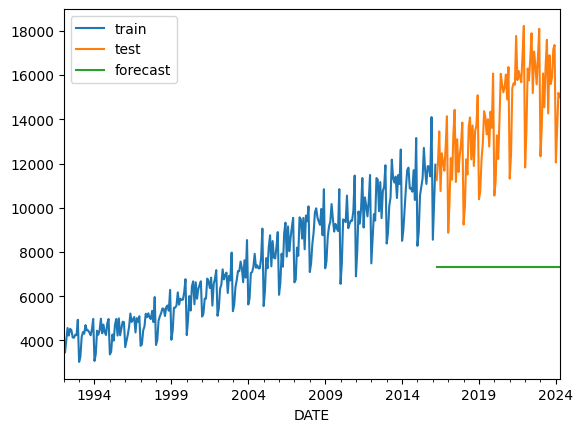

In [17]:
y_train.plot(label='train')
y_test.plot(label='test')
y_pred.plot(label='forecast')
plt.legend()
plt.show()

In [18]:
mae(y_pred, y_test)

6675.18213058419